<a href="https://colab.research.google.com/github/mehadisaki/ASDS-Thesis/blob/main/Sales_Forecasting_model_development_ARIMA_170522%C2%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [ ]:
! pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
import itertools
import statsmodels.api as sm
import pmdarima as pm
from pmdarima.arima.utils import ndiffs 
from pmdarima import arima
import time

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima 
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults



from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/TS - forcast project/new_image'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/TV%20Delivery_2016-2022.xlsx?raw=true'
url = 'https://github.com/mehadisaki/Sales-Forecasting-model-development-/blob/main/walton%20TV%20Delivery_2016-2022-m.xlsx?raw=true'
# taking link from view raw'

## indexing with datetime
df =pd.read_excel(url,index_col='Month',parse_dates=['Month'])
df.sort_index(inplace = True)
df32 = df[['Delivery']].loc[df["SIZE"] == "32\" ( 813 mm )"]


In [ ]:
 df32.head(10)

,Delivery
Month,
2016-01-01,4513
2016-02-01,5225
2016-03-01,5583
2016-04-01,5493
2016-05-01,4864
2016-06-01,9344
2016-07-01,9099
2016-08-01,10798
2016-09-01,8253


In [ ]:
df32.tail()

,Delivery
Month,
2021-11-01,18689
2021-12-01,15909
2022-01-01,22520
2022-02-01,26059
2022-03-01,24387


In [ ]:
df32.index

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
      

In [ ]:

type(df32)

pandas.core.frame.DataFrame

In [ ]:
## data type
type(df32)

pandas.core.frame.DataFrame

In [ ]:
df32.isnull().sum()

Delivery    0
dtype: int64

In [ ]:
df32.dtypes


Delivery    int64
dtype: object

##Ploting

Ploting data without datetime indexing

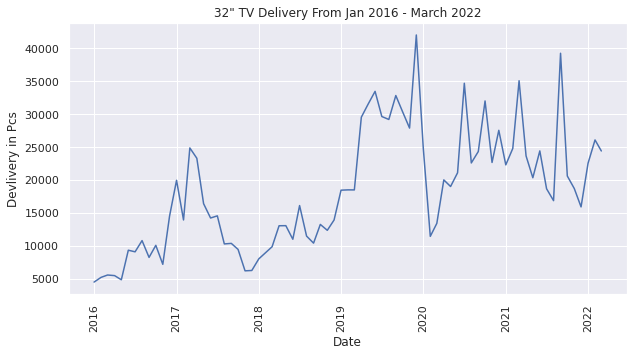

In [ ]:
# plot the time series data


plt.figure(figsize=[10, 5])
plt.plot (df32['Delivery'])
plt.title('32" TV Delivery From Jan 2016 - March 2022')
plt.ylabel('Devlivery in Pcs')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.savefig(f"{images_dir}/Sale_org.png")
plt.show()

Ploting time series with datetime indexing


## Stationary check

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df32.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df32.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.0968794004457743
p-value: 0.24577126036308022
Critial Values:
   1%, -3.524624466842421
Critial Values:
   5%, -2.9026070739026064
Critial Values:
   10%, -2.5886785262345677

KPSS Statistic: 0.871539
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


##ACF PCCF

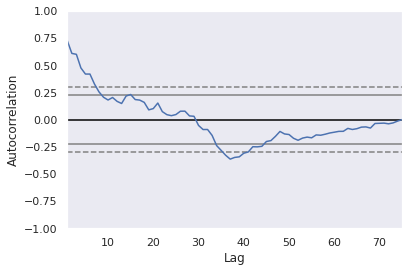

In [ ]:
autocorrelation_plot(df32)
plt.savefig(f"{images_dir}/Autocorr.png")
plt.show()

<Figure size 4800x3000 with 0 Axes>

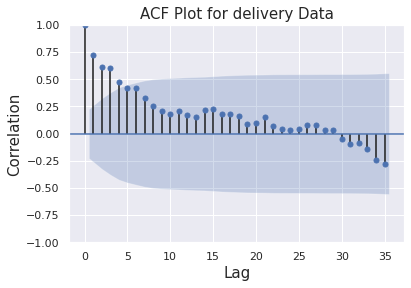

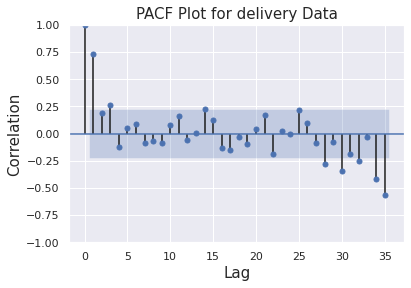

In [ ]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(16,10), dpi= 300)
#axes1 = fig.add_subplot(121)
#plot_acf(df32, lags=35, ax=axes1)
plot_acf(df32, lags=35)

plt.title("ACF Plot for delivery Data", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("ACF.png")
plt.savefig(f"{images_dir}/ACF.png")

#axes2 = fig.add_subplot(122)
#plot_pacf(df32, lags=35, ax=axes2)
plot_pacf(df32, lags=35)
plt.title("PACF Plot for delivery Data", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("PACF.png")
plt.savefig(f"{images_dir}/PACF.png")
plt.show()


### Take Difference

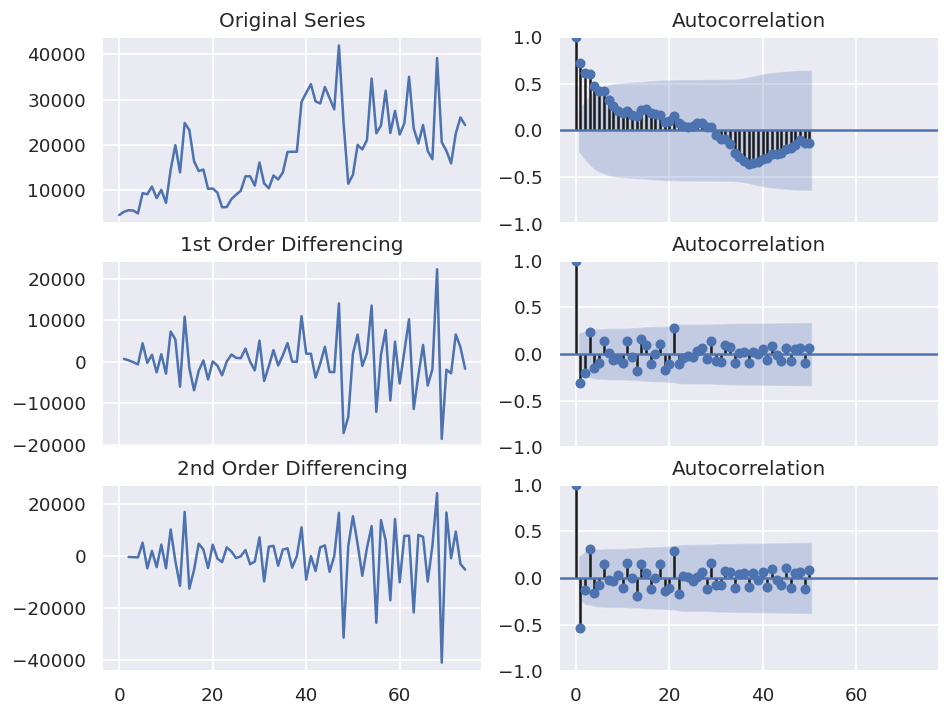

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)

axes[0, 0].plot(df32.values); axes[0, 0].set_title('Original Series')
plot_acf(df32.values,lags=50, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df32.diff().values) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df32.diff().dropna().values,lags=50, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df32.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df32.diff().diff().dropna().values,lags=50, ax=axes[2, 1])


plt.savefig("diferencing.png")
plt.savefig(f"{images_dir}/diferencing.png")

plt.show()

#Box-Cox Transformation

Box-Cox Transformation Function

In [ ]:
# Box-Cox Transformation Function
def run_box_cox(pd_dataframe):
    """
    Perform Box-Cox Transformation on column 'price'
    Save the resutls into a new column 'price_box'
    Save lmbda into a new column 'lmbda'
    """
    
    sns.set(style="darkgrid")
    f, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=False)   
    
    ax1 = axes[0, 0]    
    prob = stats.probplot(pd_dataframe['Delivery'], dist=stats.norm, plot=ax1, fit=False)    
    ax1.set_title('Probability Plot Before Transformation')
        
    ax2 = axes[0, 1]
    # Perform Box-Cox Transformation
    box_cox, lmbda = stats.boxcox(pd_dataframe['Delivery'])
    # Record new column 'price_box' in pd
    pd_dataframe['Delivery'] = pd.Series(box_cox, index=pd_dataframe.index)
    # Record lmbda in pd
    print(lmbda)
    #pd_dataframe['lmbda'] = lmbda
    prob = stats.probplot(box_cox, dist=stats.norm, plot=ax2, fit=False)
    ax2.set_title('Probability Plot After Transformation')    
    
    ax3 = axes[1, 0]
    sns.kdeplot(pd_dataframe['Delivery'], shade=True, ax=ax3, label='KDE')
    ax3.set_title('KDE Plot Before Transformation')
    
    ax4 = axes[1, 1]
    sns.kdeplot(box_cox, shade=True, ax=ax4, label='KDE after Transformation', color='r')
    ax4.set_title('KDE Plot After Transformation')
    
    f.suptitle('32"TV {} delivery after Box-Cox Transformation'.format("Monthly"), fontsize=16)
    f.subplots_adjust(top=0.91, hspace=0.3)

    plt.savefig("boxcox.png")
    plt.savefig(f"{images_dir}/boxcox.png")
    plt.show()
    return lmbda


Inverse transformation




In [ ]:
# Inverse Box-Cox Transformation Function
def inverse_box_cox(time_series, lmbda):
    """
    Inverse Box-Cox Transformation
    """
    if lmbda == 0:
      return(np.exp(time_series))
    else:
      return(np.exp(np.log(lmbda*time_series+1)/lmbda))

Apply transformation

In [ ]:
#copy dataset to save without transformation
df32_t =df32.copy()

0.3974160653494769


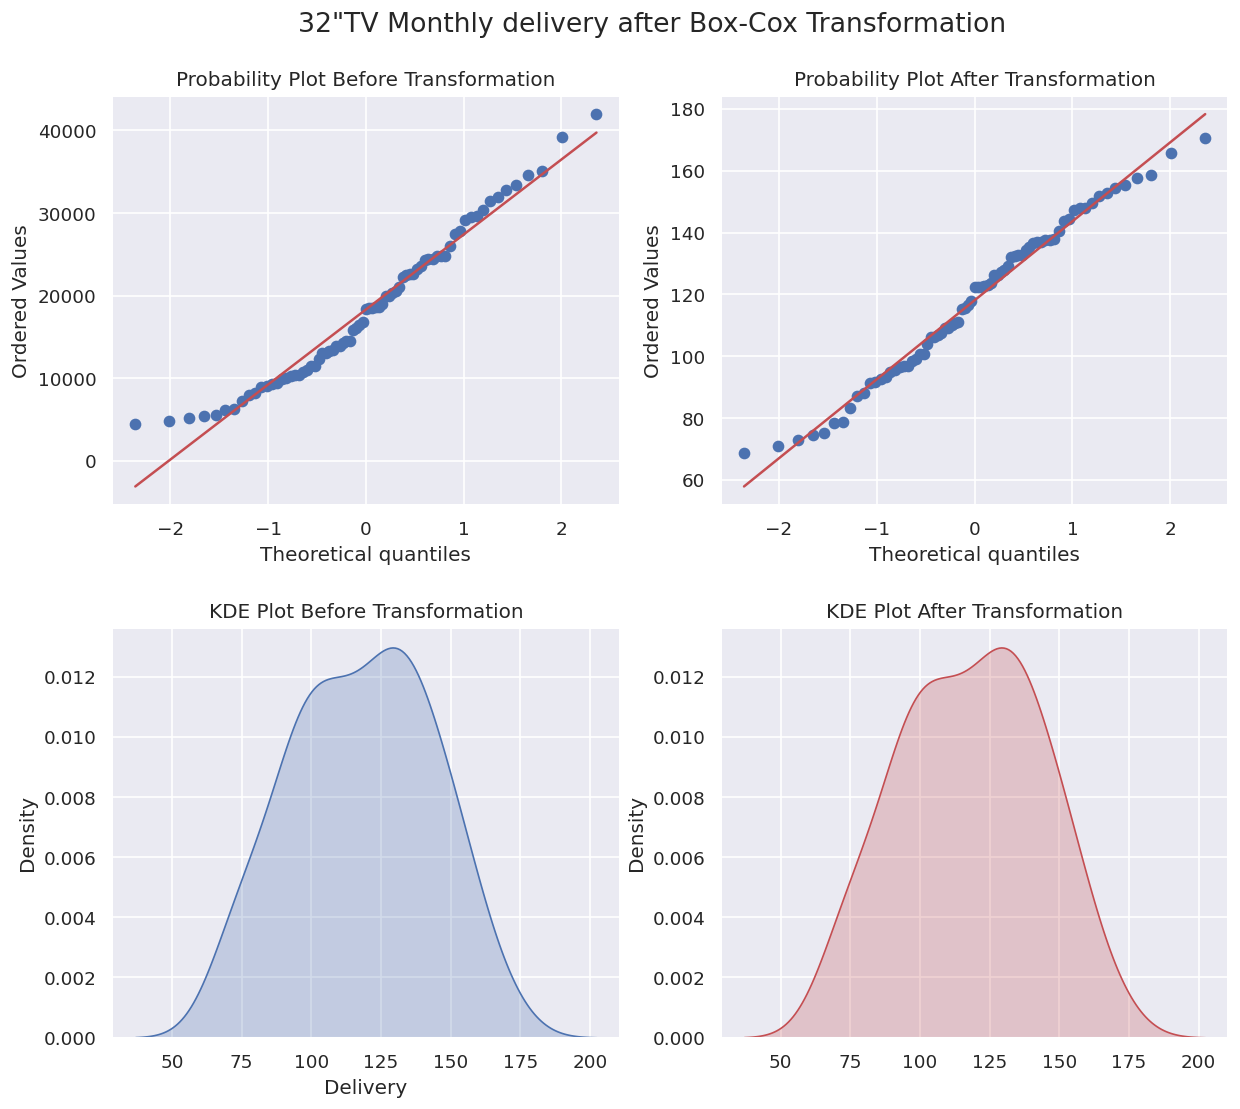

0.3974160653494769

In [ ]:
# box-cox transformation
run_box_cox(df32_t)

In [ ]:
# transformed data
df32_t.head()

,Delivery
Month,
2016-01-01,68.785106
2016-02-01,73.059381
2016-03-01,75.076286
2016-04-01,74.576754
2016-05-01,70.939370


Differencing after Transformation

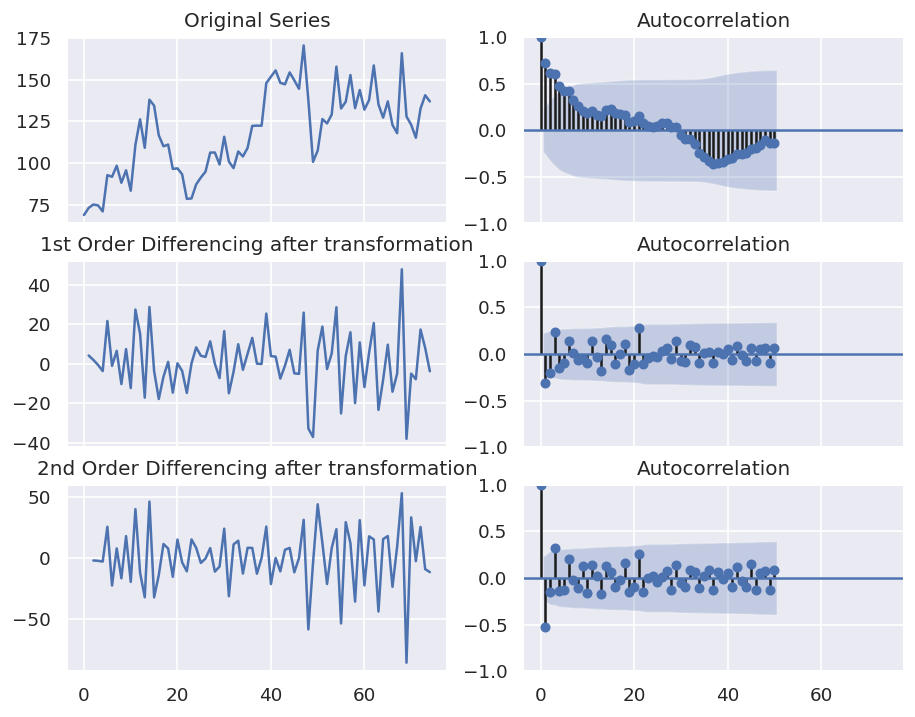

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)

axes[0, 0].plot(df32_t.values); axes[0, 0].set_title('Original Series')
plot_acf(df32.values,lags=50, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df32_t.diff().values) 
axes[1, 0].set_title('1st Order Differencing after transformation')
plot_acf(df32.diff().dropna().values,lags=50, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df32_t.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing after transformation')
plot_acf(df32_t.diff().diff().dropna().values,lags=50, ax=axes[2, 1])


plt.savefig("tr_diferencing.png")
plt.savefig(f"{images_dir}/tr_diferencing.png")

plt.show()

## ACF-PACF after Transformation

<Figure size 1600x300 with 0 Axes>

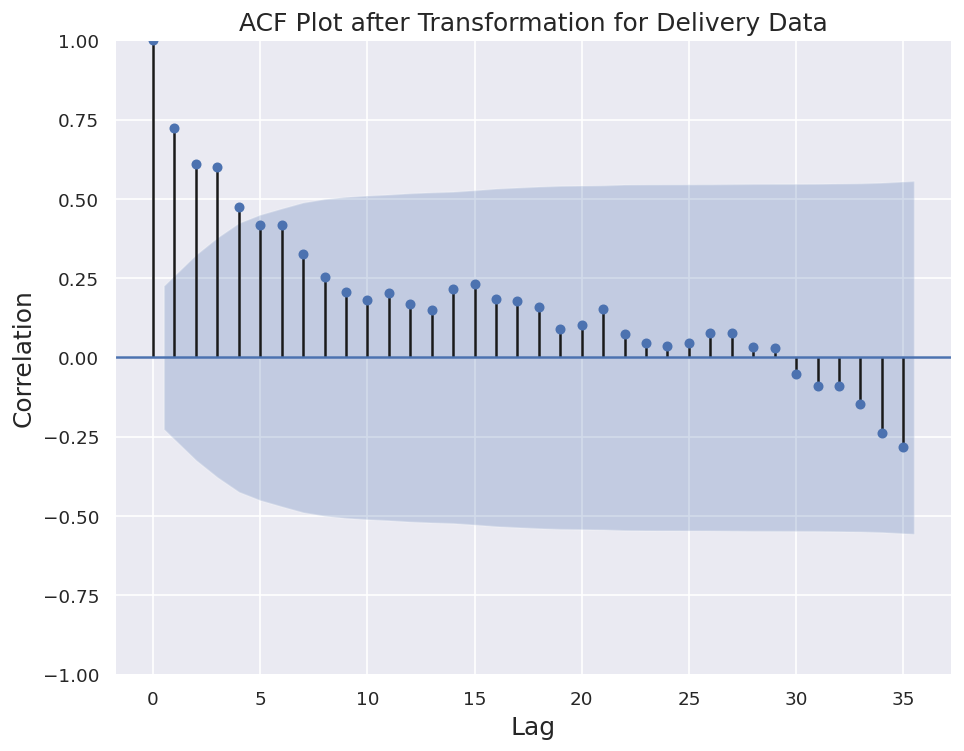

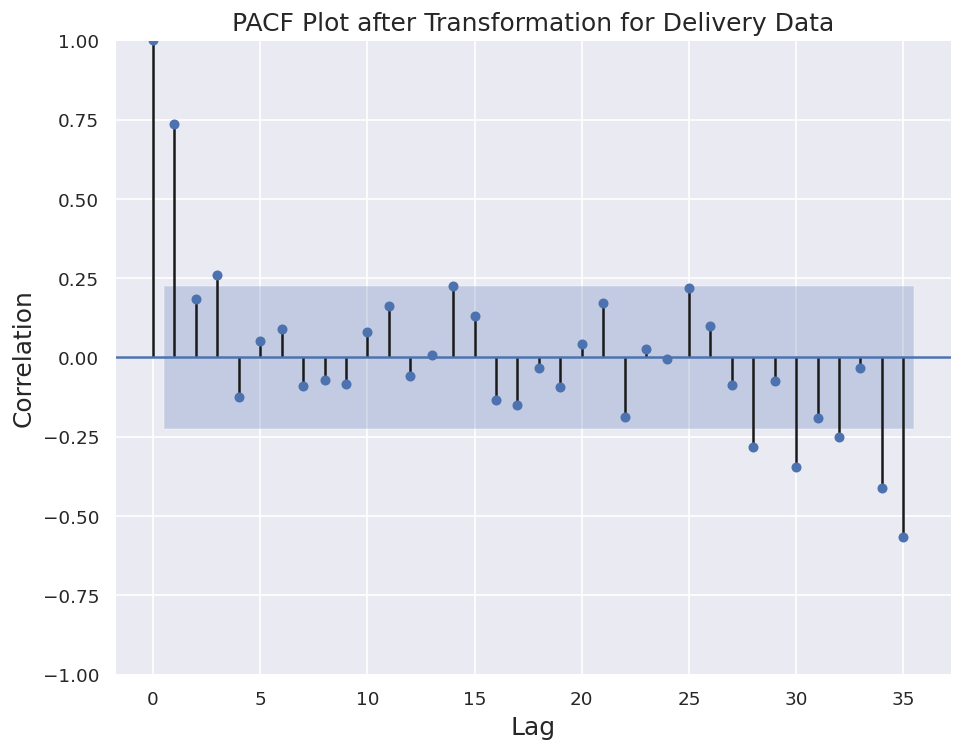

In [ ]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(16,3), dpi= 100)
#axes1 = fig.add_subplot(121)
#plot_acf(df32, lags=35, ax=axes1)
plot_acf(df32, lags=35)

plt.title("ACF Plot after Transformation for Delivery Data", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("ACF-tr.png")
plt.savefig(f"{images_dir}/ACF-tr.png")

#axes2 = fig.add_subplot(122)
#plot_pacf(df32, lags=35, ax=axes2)
plot_pacf(df32, lags=35)
plt.title("PACF Plot after Transformation for Delivery Data", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("PACF-tr.png")
plt.savefig(f"{images_dir}/PACF-tr.png")
plt.show()


In [ ]:
df32.head()

,Delivery
Month,
2016-01-01,4513
2016-02-01,5225
2016-03-01,5583
2016-04-01,5493
2016-05-01,4864


#Decomposition

STL decomposition

<Figure size 1200x1200 with 0 Axes>

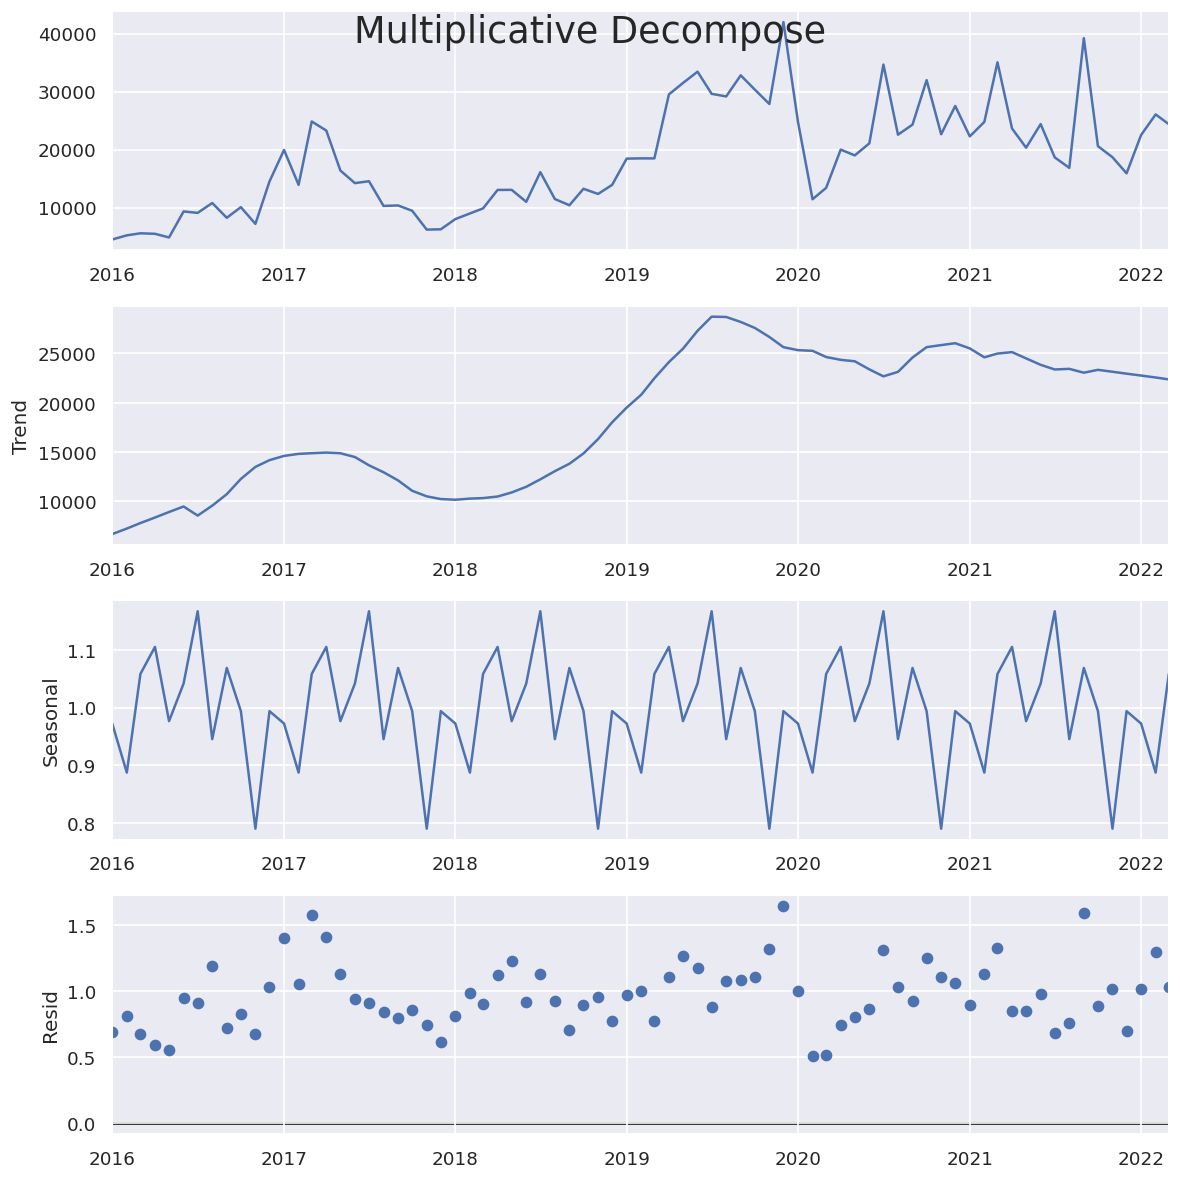

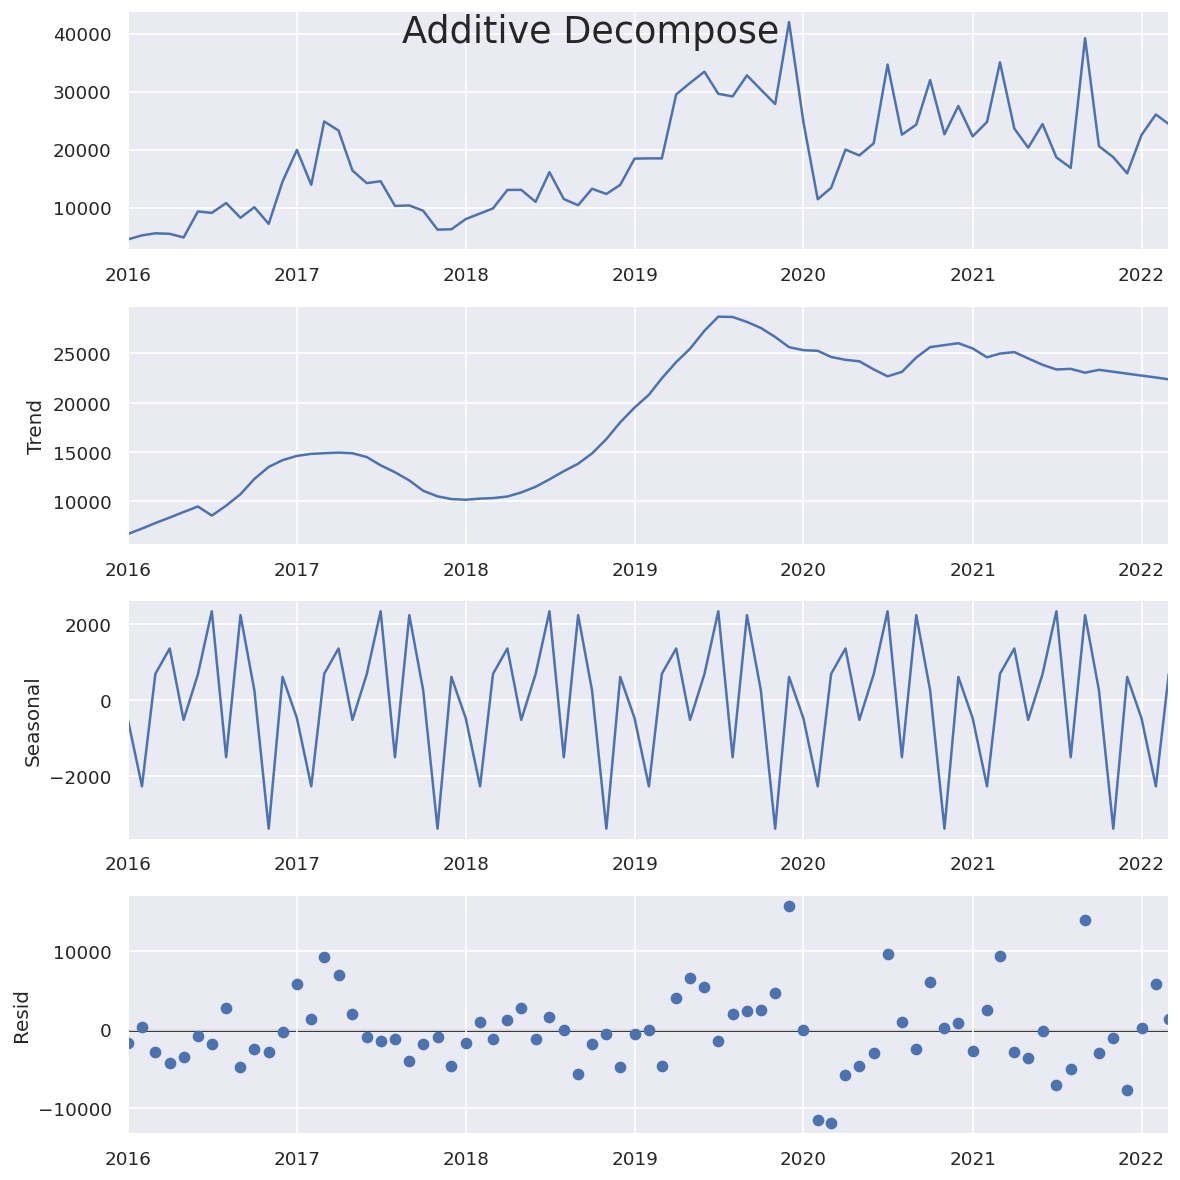

In [ ]:
#Decomposition by STL
from statsmodels.tsa.seasonal import seasonal_decompose

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df32, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df32, model='additive', extrapolate_trend='freq')

# Plot

plt.rcParams.update({'figure.figsize': (10,10)})
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
plt.savefig("MUl_d.png")
plt.savefig(f"{images_dir}/MUl_dcompose.png")
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.savefig("add_d.png")
plt.savefig(f"{images_dir}/add_dcompose.png")
plt.show()

# ARIMA

## Make the data Stationary

Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

### Test for stationary






1. Augmented Dickey Fuller test (ADH Test)
2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
3. Philips Perron test (PP Test)



In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df32_t.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df32_t.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.3476787872248046
p-value: 0.1570511592749606
Critial Values:
   1%, -3.526004646825607
Critial Values:
   5%, -2.9032002348069774
Critial Values:
   10%, -2.5889948363419957

KPSS Statistic: 0.909842
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [ ]:
 # check if need difference for make stationary
 arima.KPSSTest(alpha=0.05).should_diff(df32_t)


(0.01, True)

### Find the difference value (d)

In [ ]:
from pmdarima.arima.utils import ndiffs, nsdiffs
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)


## Adf Test
print(ndiffs(df32_t, test='adf'))  # 2

# KPSS test
print ( ndiffs(df32_t, test='kpss'))  # 0

# PP test:
print(ndiffs(df32_t, test='pp'))

1
1
0


Seasonality test

The Canova-Hansen test for seasonal differences. Canova and Hansen (1995) proposed a test statistic for the null hypothesis that the seasonal pattern is stable. The test statistic can be formulated in terms of seasonal dummies or seasonal cycles. The former allows us to identify seasons (e.g. months or quarters) that are not stable, while the latter tests the stability of seasonal cycles (e.g. cycles of period 2 and 4 quarters in quarterly data).

In [ ]:
#Seasonal deferencing check
 
## OCSBTest Test
print(nsdiffs(df32_t,m=12, test='ocsb'))  # 2

# CHTest test
print ( nsdiffs(df32_t, m=12, test='ch'))  # 0



0
0


## Parameter Selection for SARIMA


In [ ]:
p=q=d= range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12)  for x in list(itertools.product(p,d,q))]

In [ ]:
#Grid search for best ARIMA parameter 

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df32_t,order=param,seasonal_order=param_seasonal, enforce_stationarity=True,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
          continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:933.8656649759787
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:872.4309777191588
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:611.8595489404107
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:605.4867290301755
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:760.1373871052133
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:755.2080188835699
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:603.370027031627
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:604.1783821287169
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:841.5706463392182
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:786.0174980623826
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:579.4125365176574
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:572.0005212962598
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:714.62304704007
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:709.530952573012
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:571.3787648871869
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:573.1829622509416
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:615.5472752628656
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:617.5461362446122
ARIMA(0, 1, 0)

In [ ]:
## find the minimum AIC value from grid search
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic.min()))
       

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:537.3428921654244


## Auto ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=617.278, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=613.858, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=610.561, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=615.547, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=611.953, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=611.311, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=609.310, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=610.851, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=610.256, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=612.320, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.761 seconds


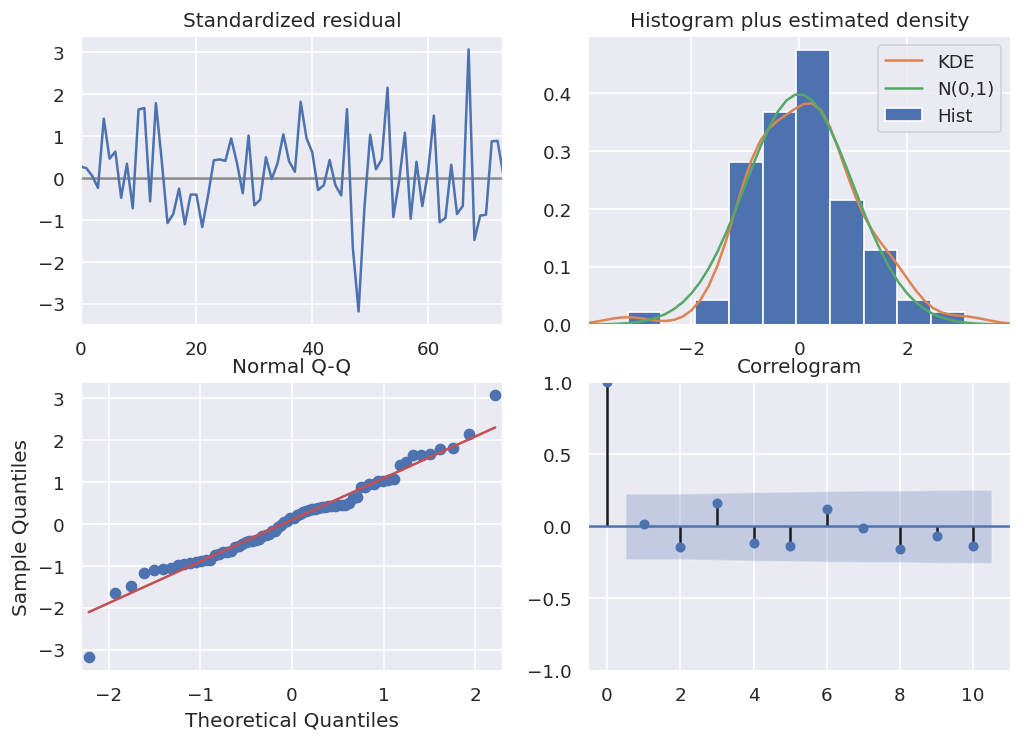

<Figure size 1200x1200 with 0 Axes>

In [ ]:
arima_model_order =  auto_arima(df32_t,start_p=0, d=None, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=0, start_Q=0, max_P=5, max_D=5, 
                          max_Q=5,seasonal=True,test='kpss', seasonal_test='ocsb', error_action='warn',
                          trace = True, supress_warnings=True,stepwise = True,
                          random_state=None, n_fits = 50)

arima_model_order.plot_diagnostics(figsize=(10,7))
plt.show()
plt.savefig("ARIM-model.png")
plt.savefig(f"{images_dir}/ARIM-model.png")

ARIMA model with autoArima

In [ ]:
df32_t.index

DatetimeIndex(['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
      

Auto ARIMA function for finding best ARIMA model

In [ ]:
arima_model_order.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   75
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -302.655
Date:                Thu, 19 May 2022   AIC                            609.310
Time:                        15:43:33   BIC                            613.918
Sample:                             0   HQIC                           611.148
                                 - 75                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3754      0.106     -3.557      0.000      -0.582      -0.169
sigma2       208.4981     27.800      7.500      0.000     154.011     262.985
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 3.37
Prob(Q):                              0.87   Prob(JB):                         0.19
Heteroskedasticity (H):               1.67   Skew:                             0.06
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Model build up

In [ ]:
#Split into test and train data
train_data, test_data = train_test_split(df32_t, test_size=0.20, shuffle = False)
print("Train data")
print(train_data.head())
print("Test Data")
print(test_data.tail())

Train data
             Delivery
Month                
2016-01-01  68.785106
2016-02-01  73.059381
2016-03-01  75.076286
2016-04-01  74.576754
2016-05-01  70.939370
Test Data
              Delivery
Month                 
2021-11-01  122.899330
2021-12-01  115.123731
2022-01-01  132.546369
2022-02-01  140.612579
2022-03-01  136.889853


## ARIMA model

### ARIMA-1

In [ ]:
# Build Model
#timestamp = time.time()
# model order from auto arima 
model_1 = ARIMA(train_data, order= arima_model_order.order, enforce_stationarity=True, )  
fitted = model_1.fit()  

print(fitted.summary())
fcast = fitted.get_forecast(len(test_data), alpha=0.05).summary_frame()



                               SARIMAX Results                                
Dep. Variable:               Delivery   No. Observations:                   60
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -237.818
Date:                Thu, 19 May 2022   AIC                            479.635
Time:                        15:43:33   BIC                            483.790
Sample:                    01-01-2016   HQIC                           481.257
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2531      0.124     -2.049      0.040      -0.495      -0.011
sigma2       185.4113     29.943      6.192      0.000     126.724     244.098
Ljung-Box (L1) (Q):                   0.00   Jarque-

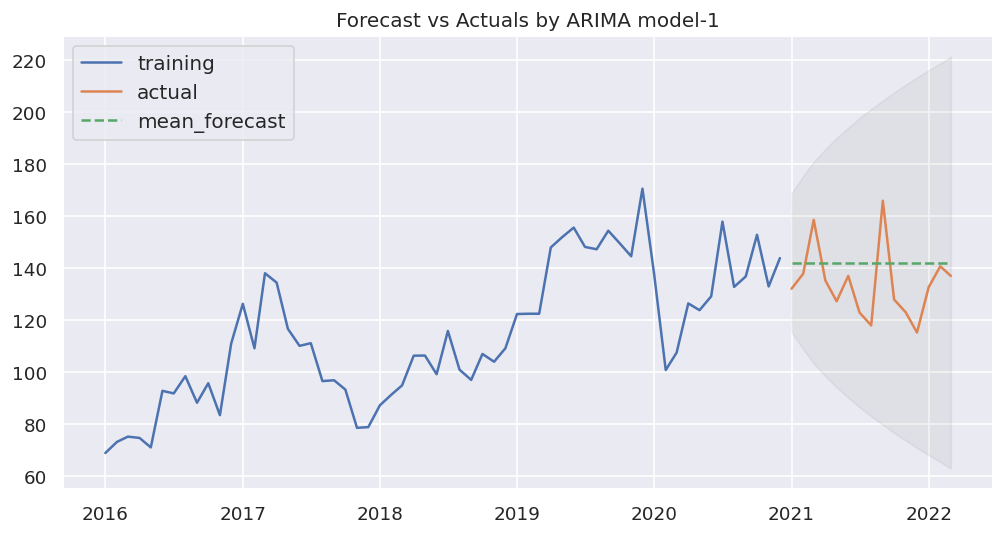

In [ ]:
# plot the forcasting data
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')

plt.plot(fcast['mean'],'g--', label='mean_forecast')

ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05);
plt.title('Forecast vs Actuals by ARIMA model-1')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Forecast_ARIMA_model_1.png')
plt.savefig(f"{images_dir}/Forecast_ARIMA_model_1.png")

##Plot the residual

In [ ]:
fitted.resid.head()


Month
2016-01-01    68.785106
2016-02-01     4.277503
2016-03-01     3.034421
2016-04-01     0.265570
2016-05-01    -3.570181
dtype: float64

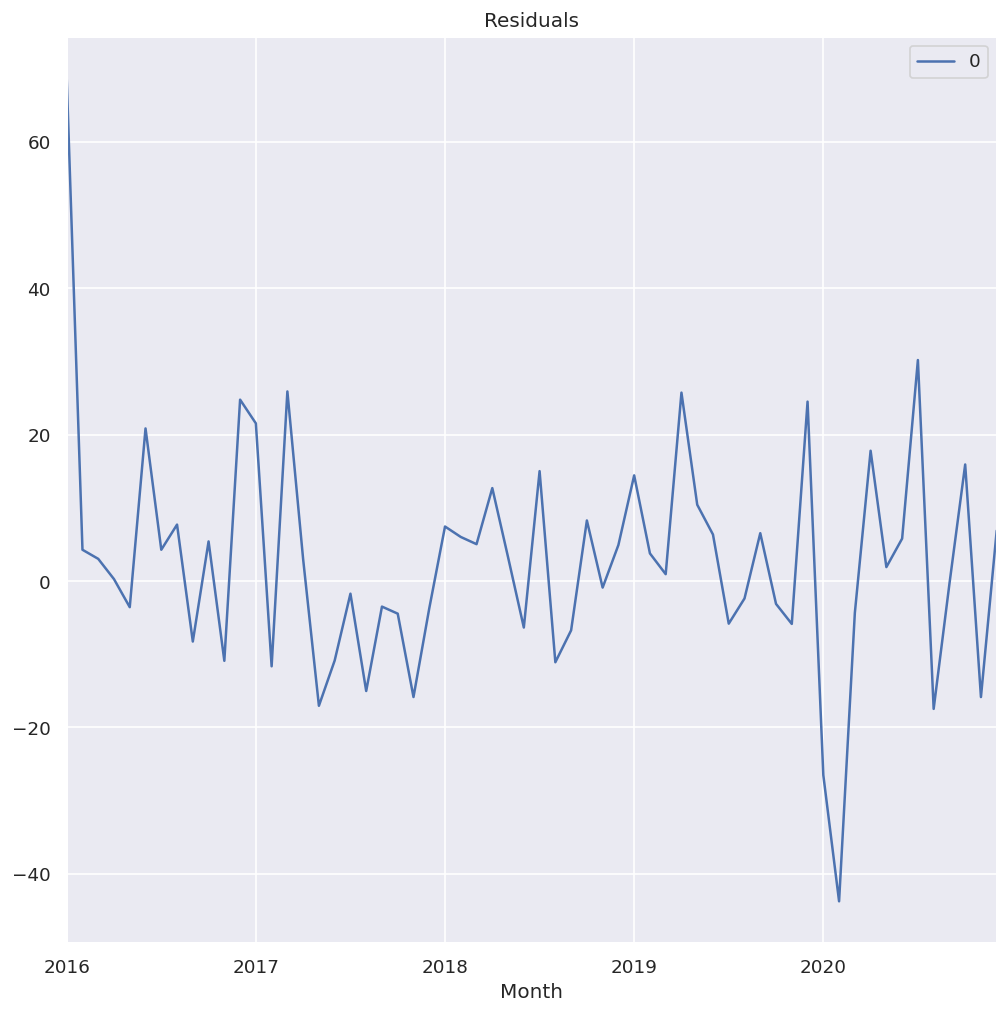

In [ ]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot(title="Residuals")
plt.savefig('Re_ARIMA_model_1.png')
plt.savefig(f"{images_dir}/Re_ARIMA_model_1.png")
plt.show()


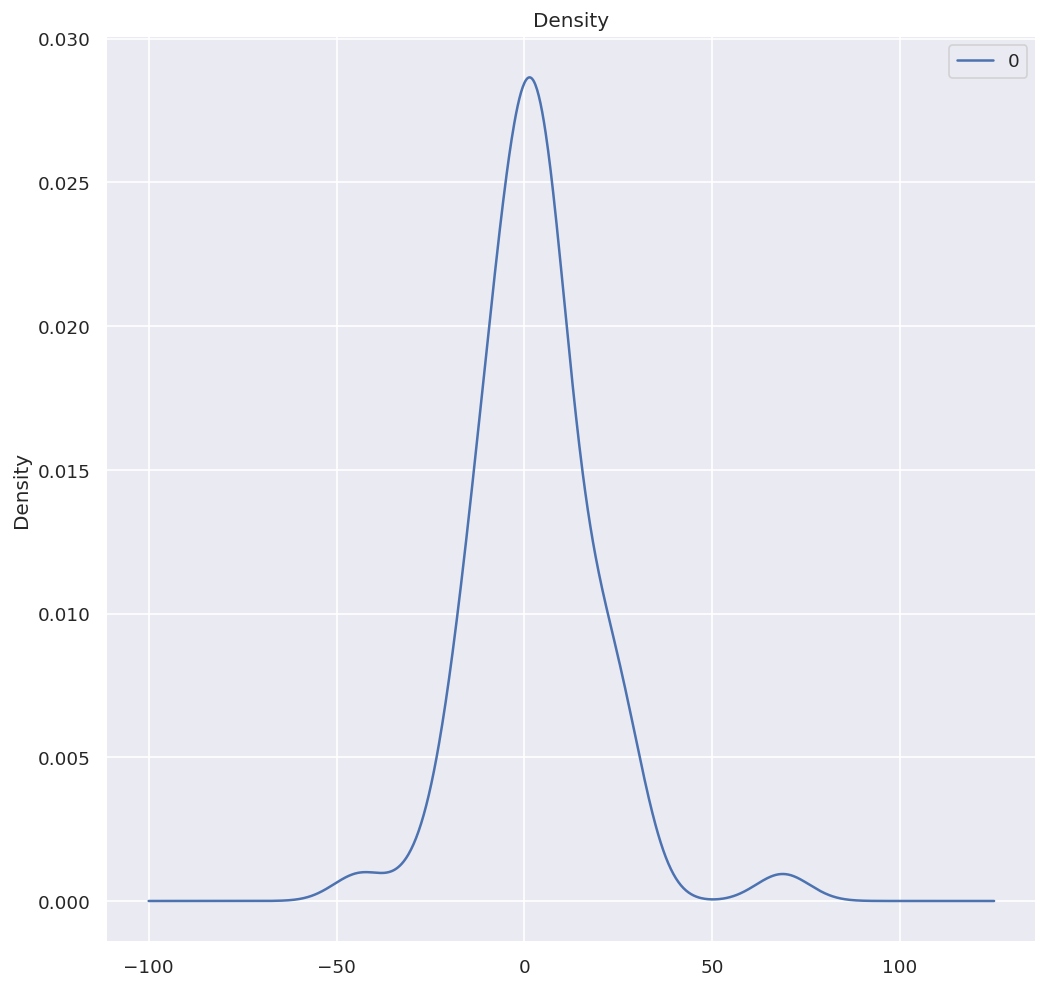

In [ ]:
residuals = pd.DataFrame(fitted.resid)

residuals.plot(kind='kde',title="Density")
plt.savefig('Re__de_ARIMA_model_1.png')
plt.savefig(f"{images_dir}/Re_de_ARIMA_model_1.png")
plt.show()


In [ ]:
# residual of ARIMA Model-1
print(residuals.describe())

               0
count  60.000000
mean    2.778815
std    16.055465
min   -43.761803
25%    -5.829930
50%     3.003094
75%     7.857161
max    68.785106


ACF PACF of residuals

<Figure size 1600x300 with 0 Axes>

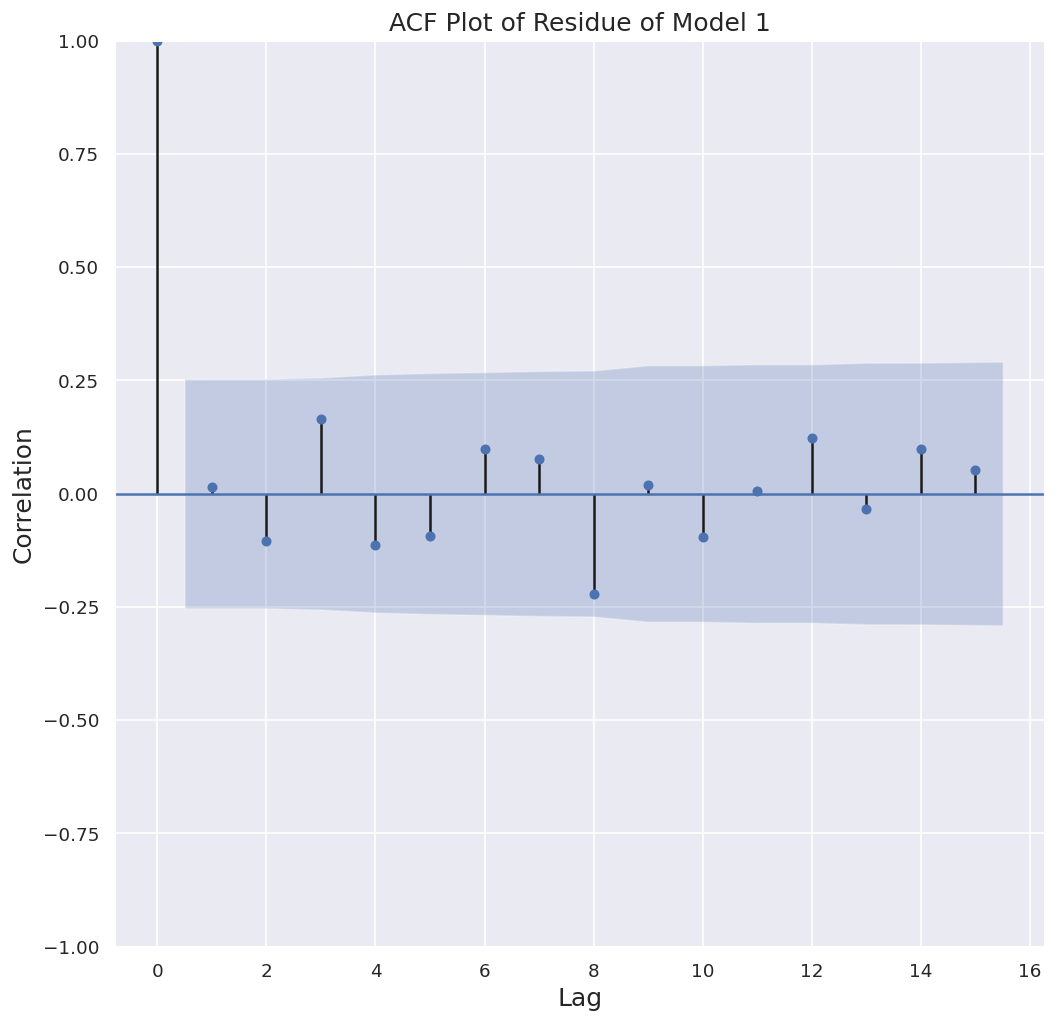

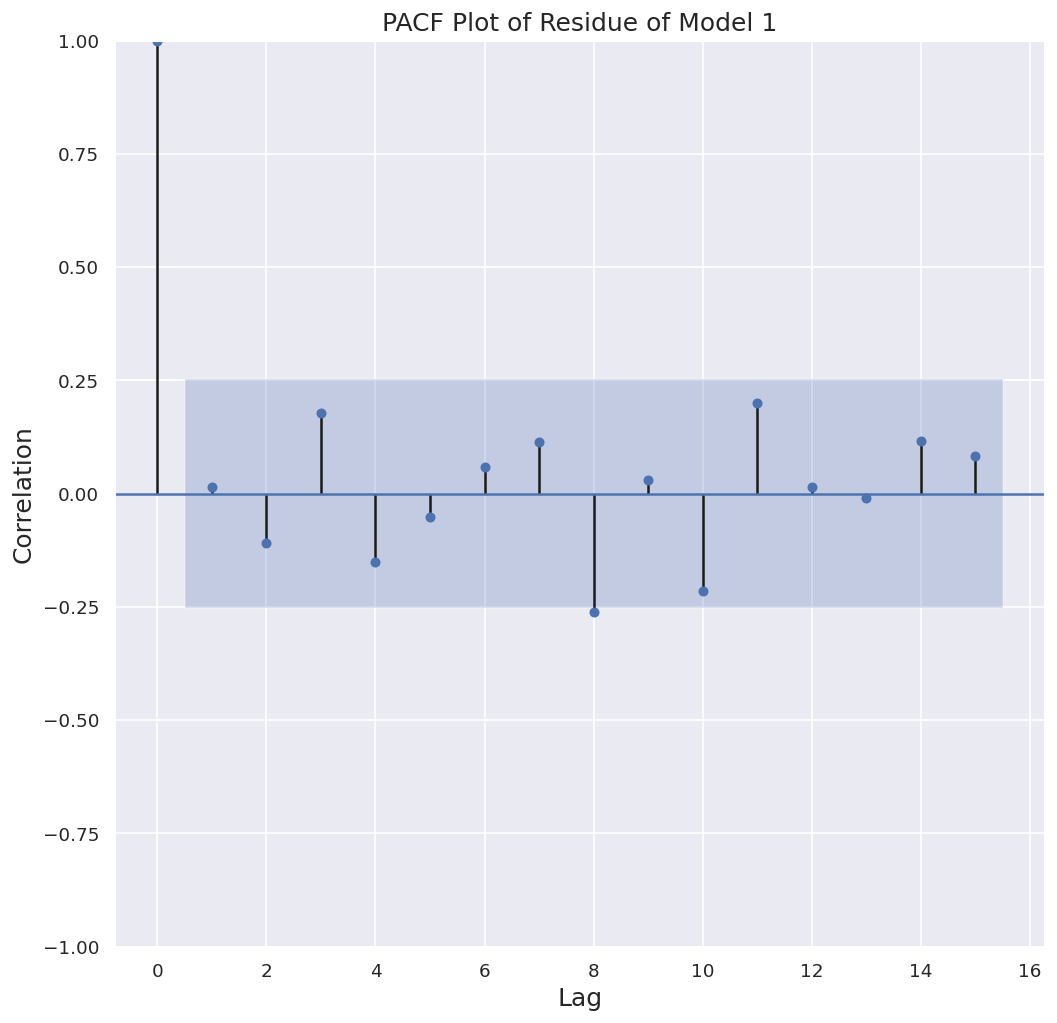

In [ ]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(16,3), dpi= 100)
#axes1 = fig.add_subplot(121)
#plot_acf(df32, lags=35, ax=axes1)
plot_acf(residuals, lags=15)

plt.title("ACF Plot of Residue of Model 1", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("ACF-re1.png")
plt.savefig(f"{images_dir}/ACF-re1.png")

#axes2 = fig.add_subplot(122)
#plot_pacf(df32, lags=35, ax=axes2)
plot_pacf(residuals, lags=15)
plt.title("PACF Plot of Residue of Model 1", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("PACF-res1.png")
plt.savefig(f"{images_dir}/PACF-res1.png")
plt.show()


##ARIMA model-2 

In [ ]:
# Build Model

# model order (1, 1, 1)(1, 1, 1)[12] arima 

model_2=SARIMAX(train_data,order=(1, 1, 1),seasonal_order=(1,1,1,12),trend="t")
Sarimares=model_2.fit()

print(Sarimares.summary())
fscast = Sarimares.get_forecast(len(test_data), alpha=0.05).summary_frame()

                                     SARIMAX Results                                      
Dep. Variable:                           Delivery   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -195.260
Date:                            Thu, 19 May 2022   AIC                            402.521
Time:                                    15:43:40   BIC                            413.622
Sample:                                01-01-2016   HQIC                           406.698
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift         -0.0144      0.089     -0.162      0.871      -0.188       0.160
ar.L1         -0.8937      0.300   

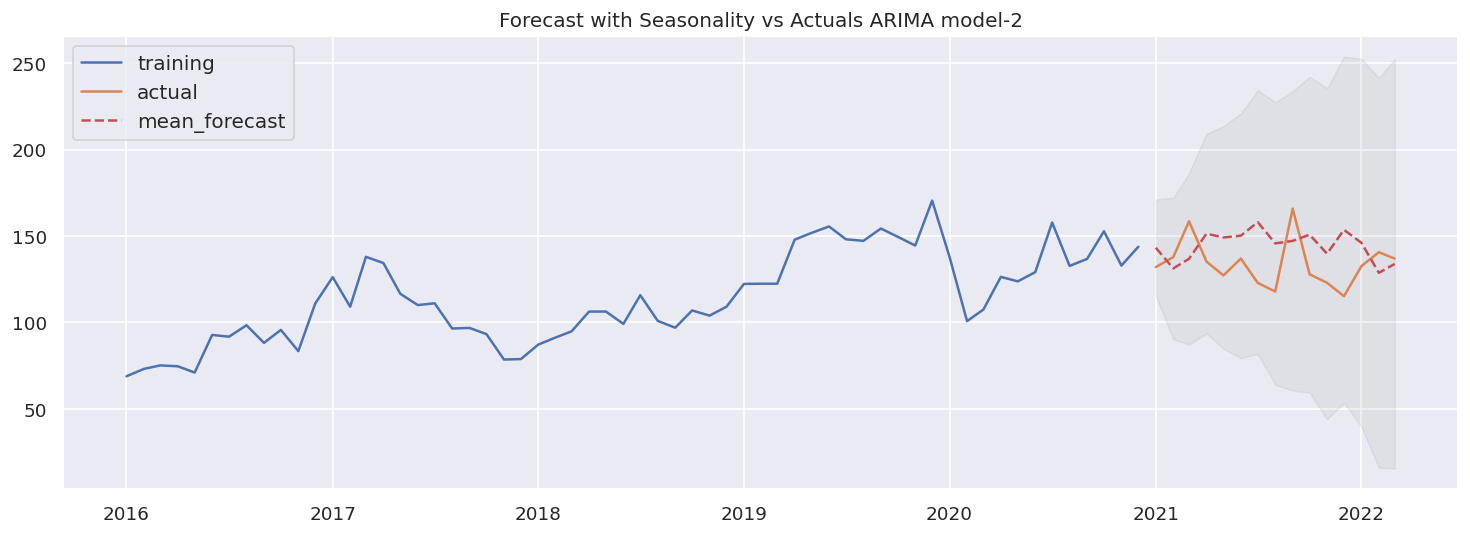

In [ ]:
# plot the forcasting data
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')

plt.plot(fscast['mean'],'r--', label='mean_forecast')
ax.fill_between(fscast.index, fscast['mean_ci_lower'], fscast['mean_ci_upper'], color='k', alpha=0.05)
plt.title('Forecast with Seasonality vs Actuals ARIMA model-2')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Forecast_SARIMA.png')
plt.savefig(f"{images_dir}/Forecast_SARIMA.png")
plt.show()


### plot residue

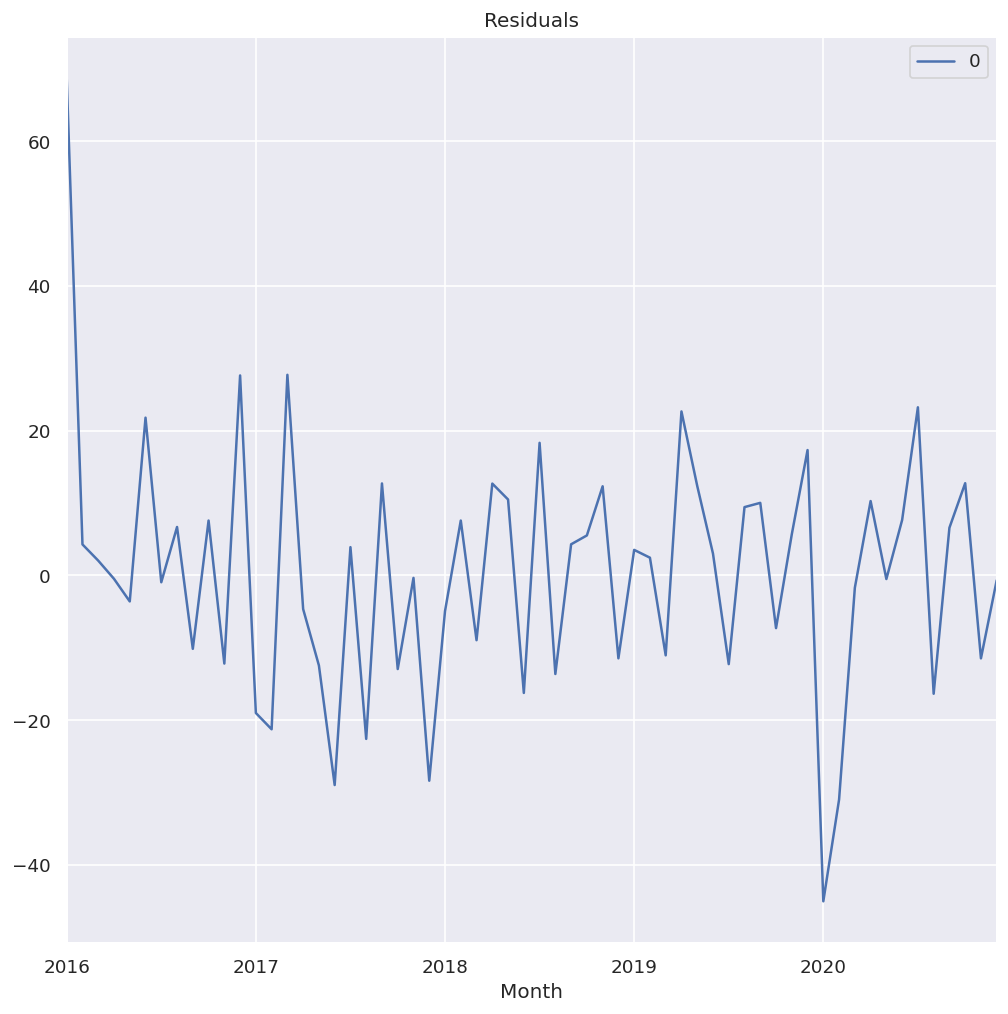

In [ ]:
residuals = pd.DataFrame(Sarimares.resid)
residuals.plot(title="Residuals")
plt.savefig('Re_ARIMA_model_2.png')
plt.savefig(f"{images_dir}/Re_ARIMA_model_2.png")
plt.show()




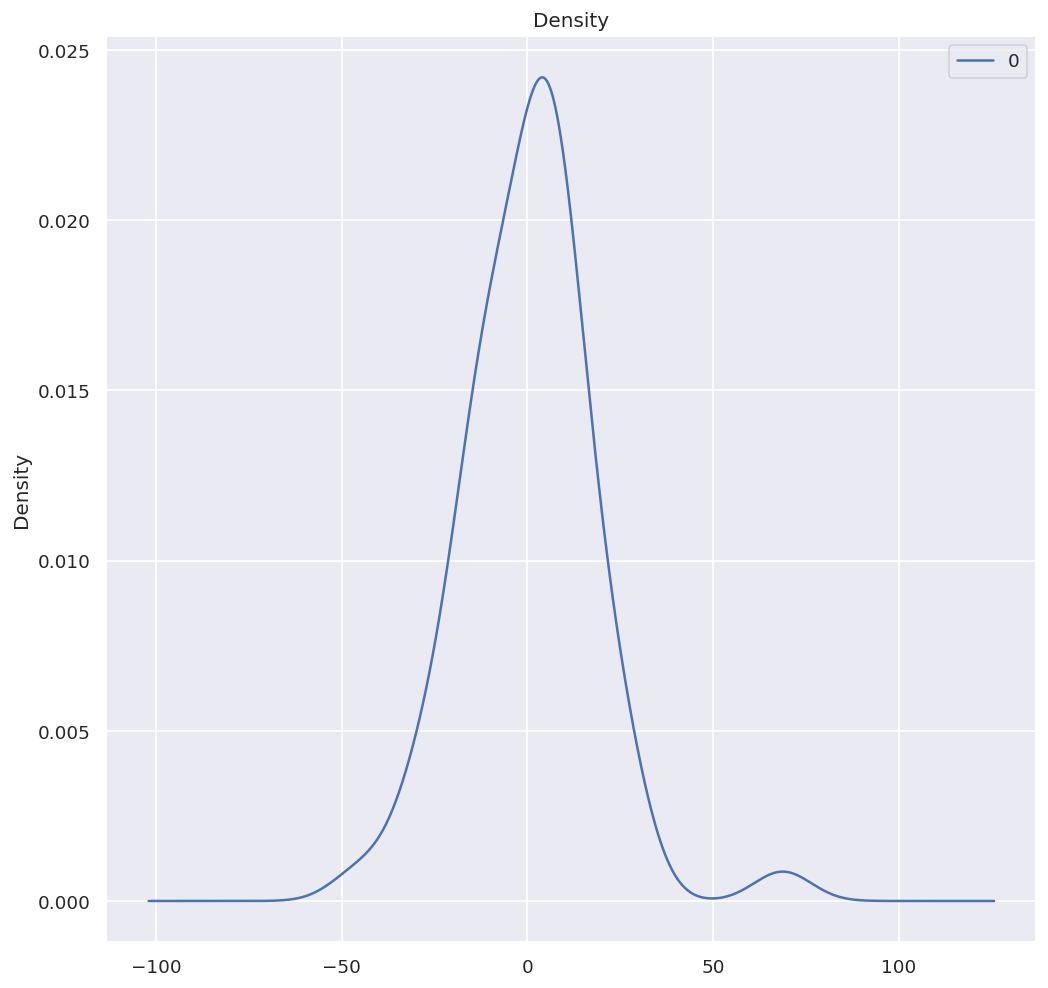

In [ ]:
residuals2 = pd.DataFrame(Sarimares.resid)
residuals2.plot(kind='kde',title="Density")
plt.savefig('Re__de_ARIMA_model_2.png')
plt.savefig(f"{images_dir}/Re_de_ARIMA_model_2.png")
plt.show()


In [ ]:
# residual of ARIMA Model-1
print(residuals2.describe())

               0
count  60.000000
mean    0.509992
std    17.466908
min   -45.052525
25%   -11.468517
50%     2.241067
75%    10.085392
max    68.791465


<Figure size 1600x300 with 0 Axes>

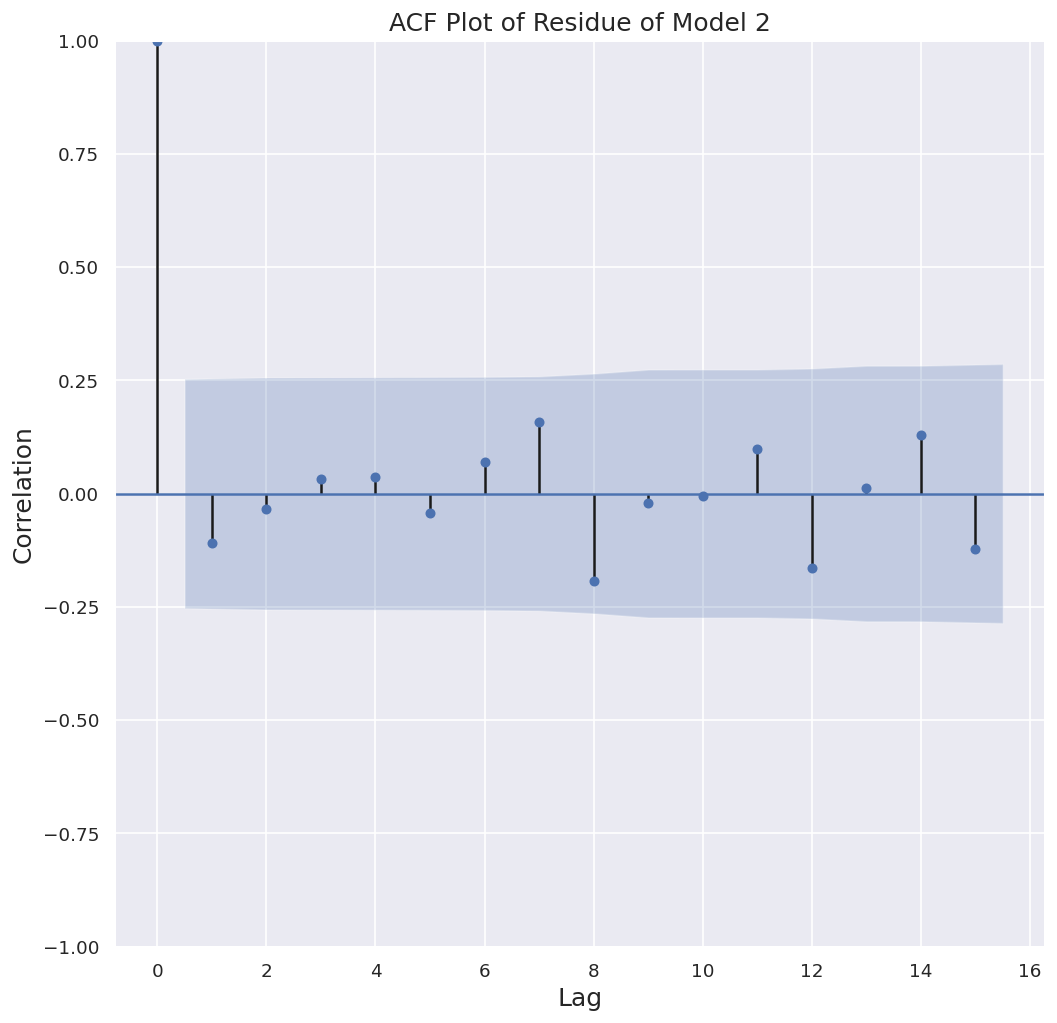

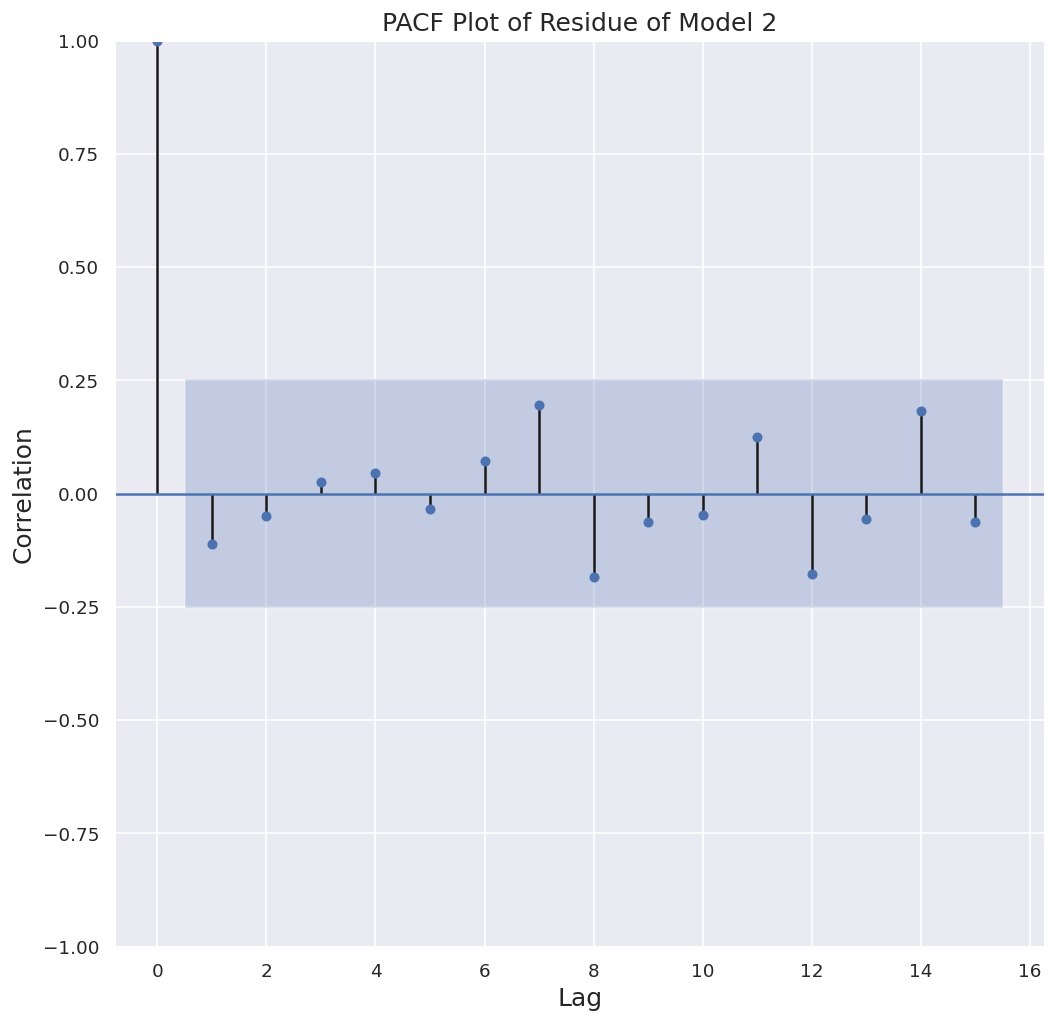

In [ ]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(16,3), dpi= 100)
#axes1 = fig.add_subplot(121)
#plot_acf(df32, lags=35, ax=axes1)
plot_acf(residuals2, lags=15)

plt.title("ACF Plot of Residue of Model 2", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("ACF-re2.png")
plt.savefig(f"{images_dir}/ACF-re2.png")

#axes2 = fig.add_subplot(122)
#plot_pacf(df32, lags=35, ax=axes2)
plot_pacf(residuals2, lags=15)
plt.title("PACF Plot of Residue of Model 2", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("PACF-res2.png")
plt.savefig(f"{images_dir}/PACF-res2.png")
plt.show()


## ARIMA model-3

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df32_t, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=556.238, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=546.566, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=555.812, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=542.548, Time=0.40 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.73 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=542.776, Time=0.25 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=541.802, Time=0.47 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=544.992, Time=0.17 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=543.676, Time=0.49 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=543.409, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   75
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -265.478
Date:                             Thu, 19 May 2022   AIC                            540.955
Time:                                     15:44:05   BIC                            551.591
Sample:                                          0   HQIC                           545.131
                                              - 75                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7100      0.154      4.621      0.000       0.409       1.011
ma.L1         -0.9618      0.119     -8.086      0.000      -1.195      -0.729
ar.S.L12      -0.7360      0.221     -3.332      0.001      -1.169      -0.303
ar.S.L24      -0.3953      0.197     -2.009      0.045      -0.781      -0.010
sigma2       261.4552     53.880      4.853      0.000     155.852     367.058
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.58   Prob(JB):                         0.71
Heteroskedasticity (H):               2.55   Skew:                            -0.26
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Build Model 3

# model order ARIMA(1,1,1)(2,1,0)[12] 

model_3=SARIMAX(train_data,order=(1, 1, 1),seasonal_order=(2,1,0,12))
Sarimares3=model_3.fit()

print(Sarimares3.summary())
fscast3 = Sarimares3.get_forecast(len(test_data), alpha=0.05).summary_frame()

                                      SARIMAX Results                                      
Dep. Variable:                            Delivery   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -194.485
Date:                             Thu, 19 May 2022   AIC                            398.969
Time:                                     15:44:07   BIC                            408.220
Sample:                                 01-01-2016   HQIC                           402.450
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8715      0.265     -3.284      0.001      -1.392      -0.351
ma.L1          0.9996     3

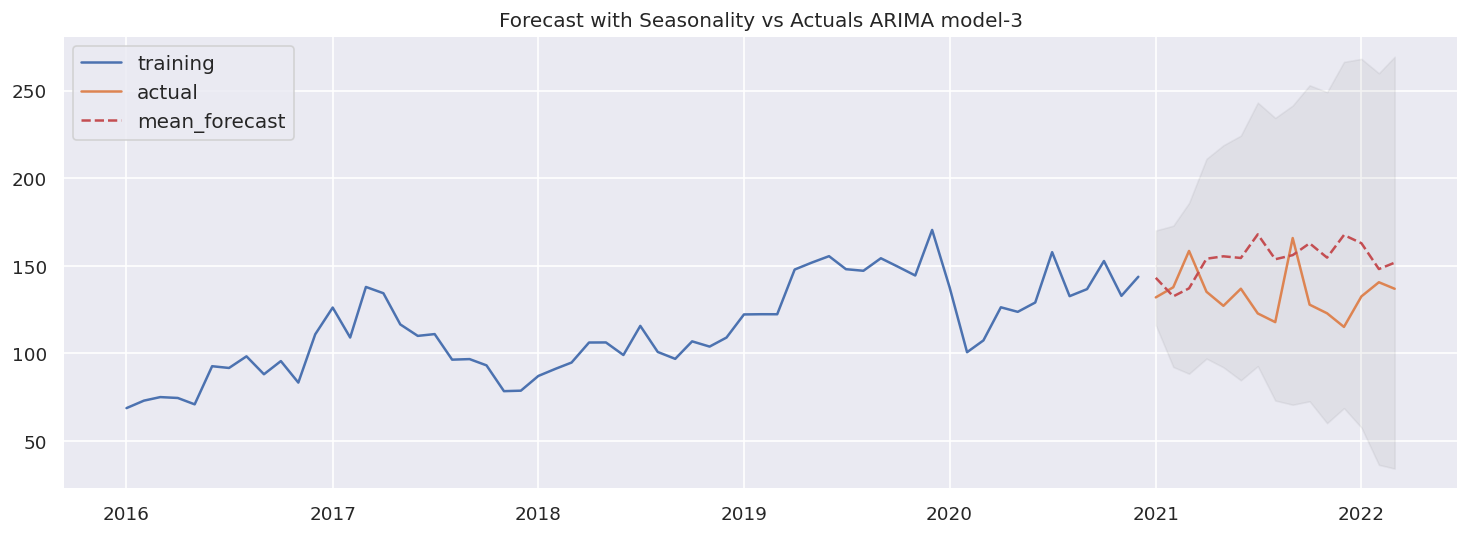

In [ ]:
# plot the forcasting data
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual')

plt.plot(fscast3['mean'],'r--', label='mean_forecast')
ax.fill_between(fscast3.index, fscast3['mean_ci_lower'], fscast3['mean_ci_upper'], color='k', alpha=0.05)
plt.title('Forecast with Seasonality vs Actuals ARIMA model-3')
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Forecast_SARIMA_3.png')
plt.savefig(f"{images_dir}/Forecast_SARIMA_3.png")
plt.show()


### plot Residue


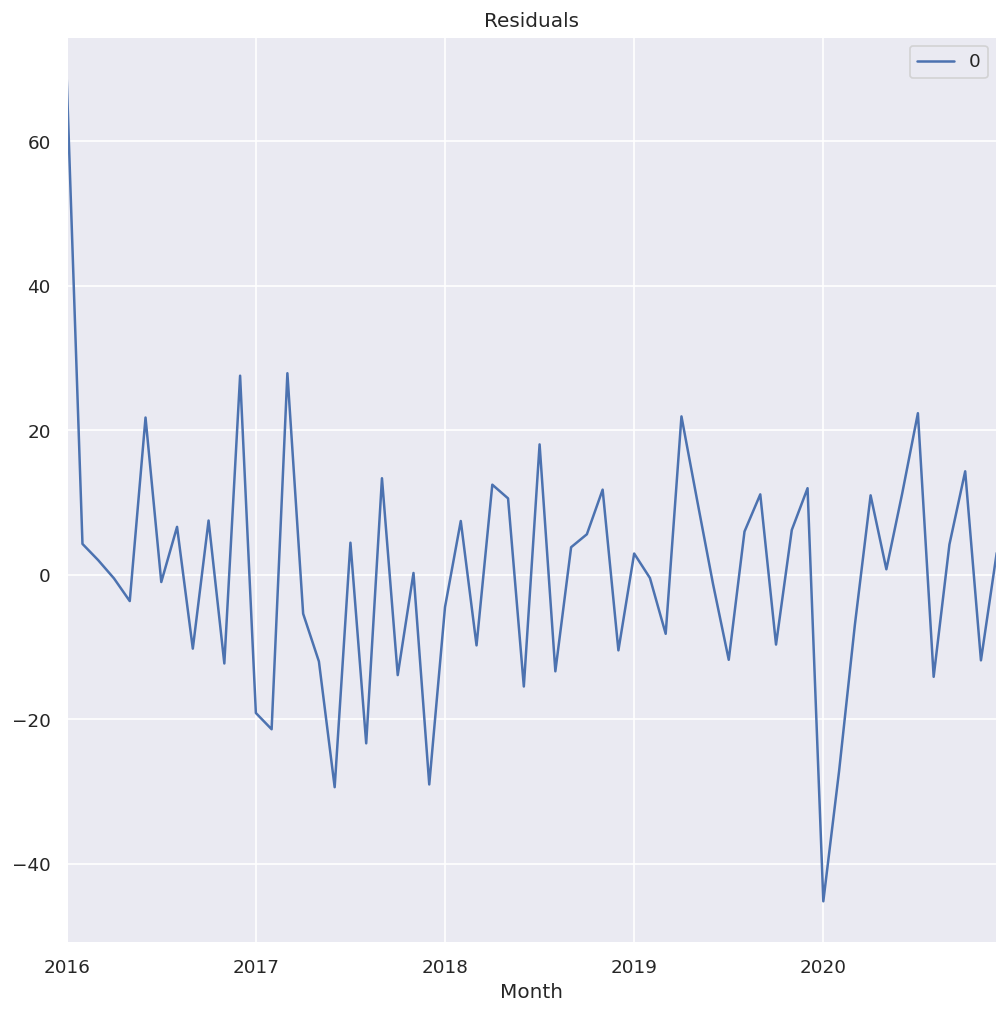

In [ ]:
residuals3 = pd.DataFrame(Sarimares3.resid)
residuals3.plot(title="Residuals")
plt.savefig('Re_ARIMA_model_3.png')
plt.savefig(f"{images_dir}/Re_ARIMA_model_3.png")
plt.show()




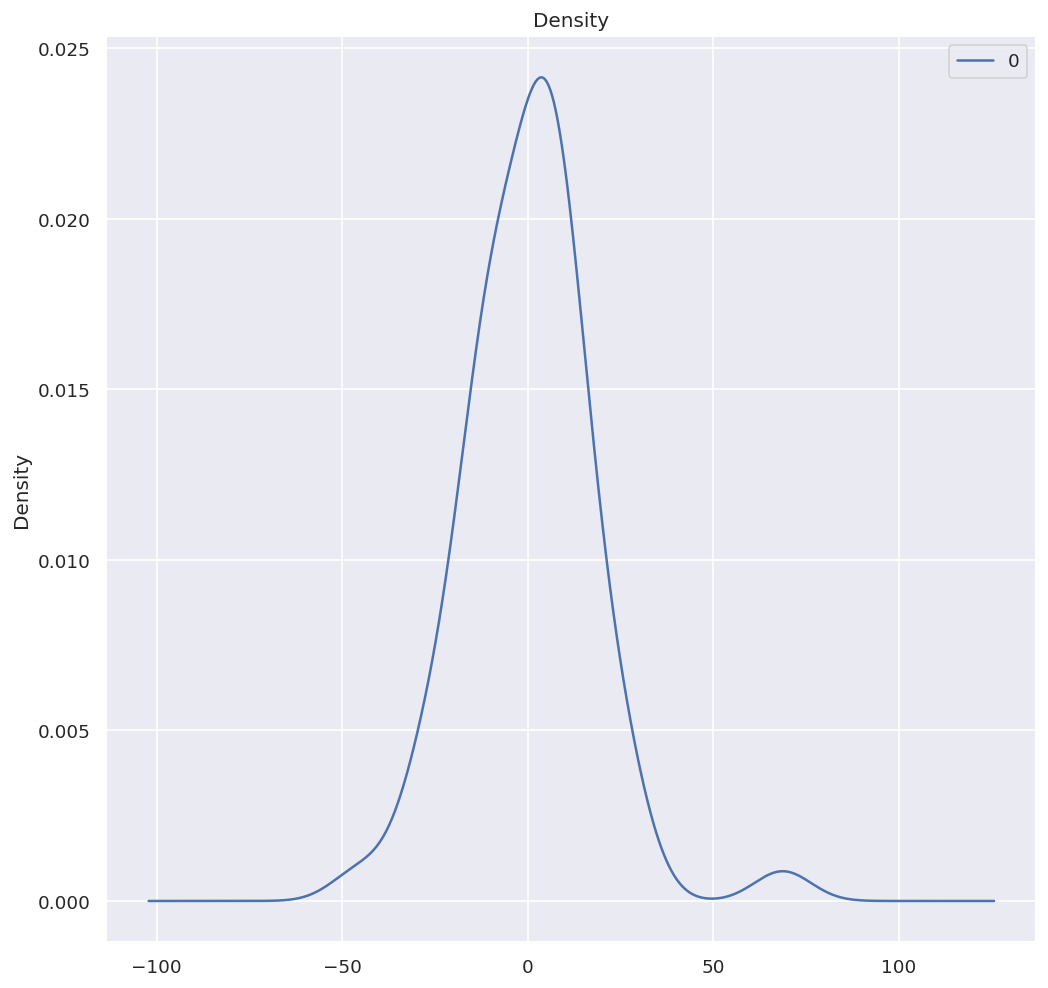

In [ ]:
residuals3 = pd.DataFrame(Sarimares3.resid)
residuals3.plot(kind='kde',title="Density")
plt.savefig('Re__de_ARIMA_model_3.png')
plt.savefig(f"{images_dir}/Re_de_ARIMA_model_3.png")
plt.show()


In [ ]:
# residual of ARIMA Model-1
print(residuals3.describe())

               0
count  60.000000
mean    0.338984
std    17.281050
min   -45.180945
25%   -10.781591
50%     1.390570
75%    10.676345
max    68.785106


<Figure size 1600x300 with 0 Axes>

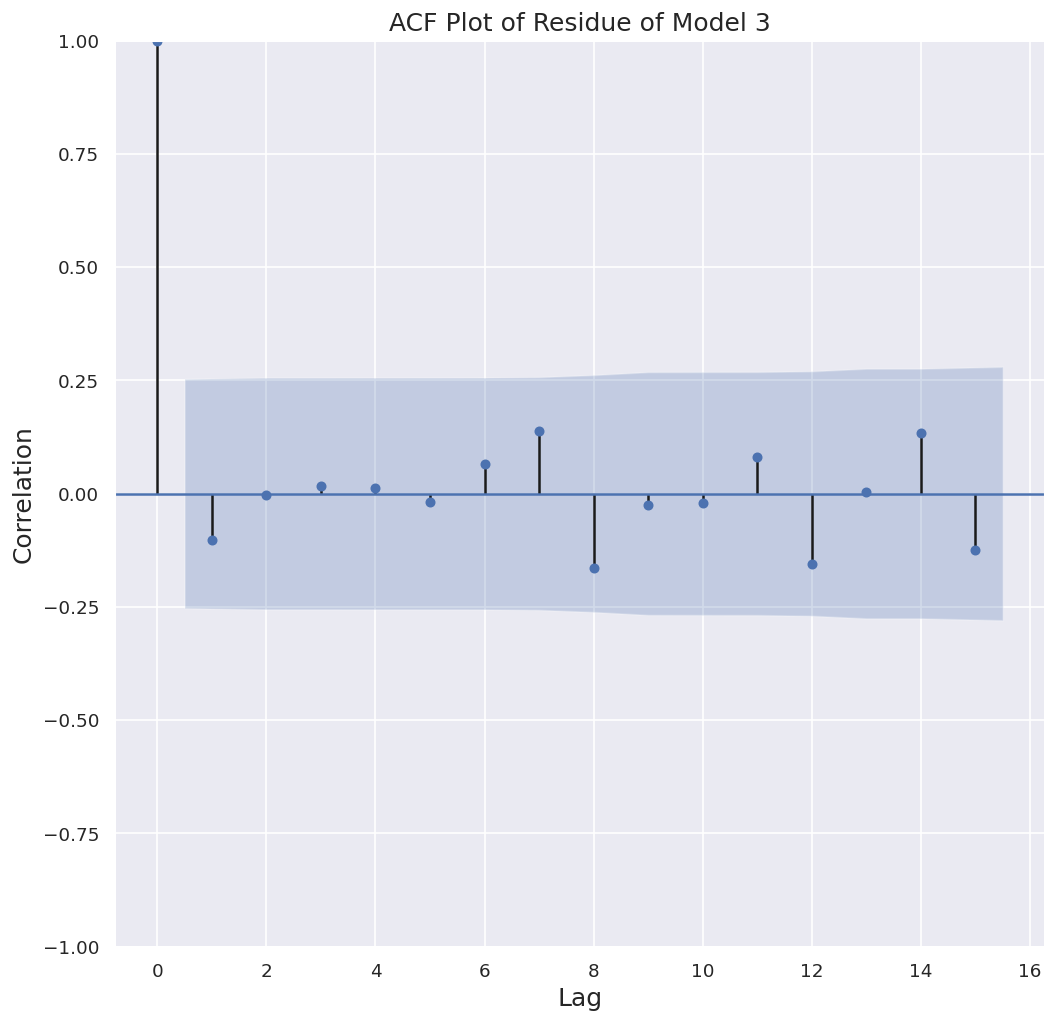

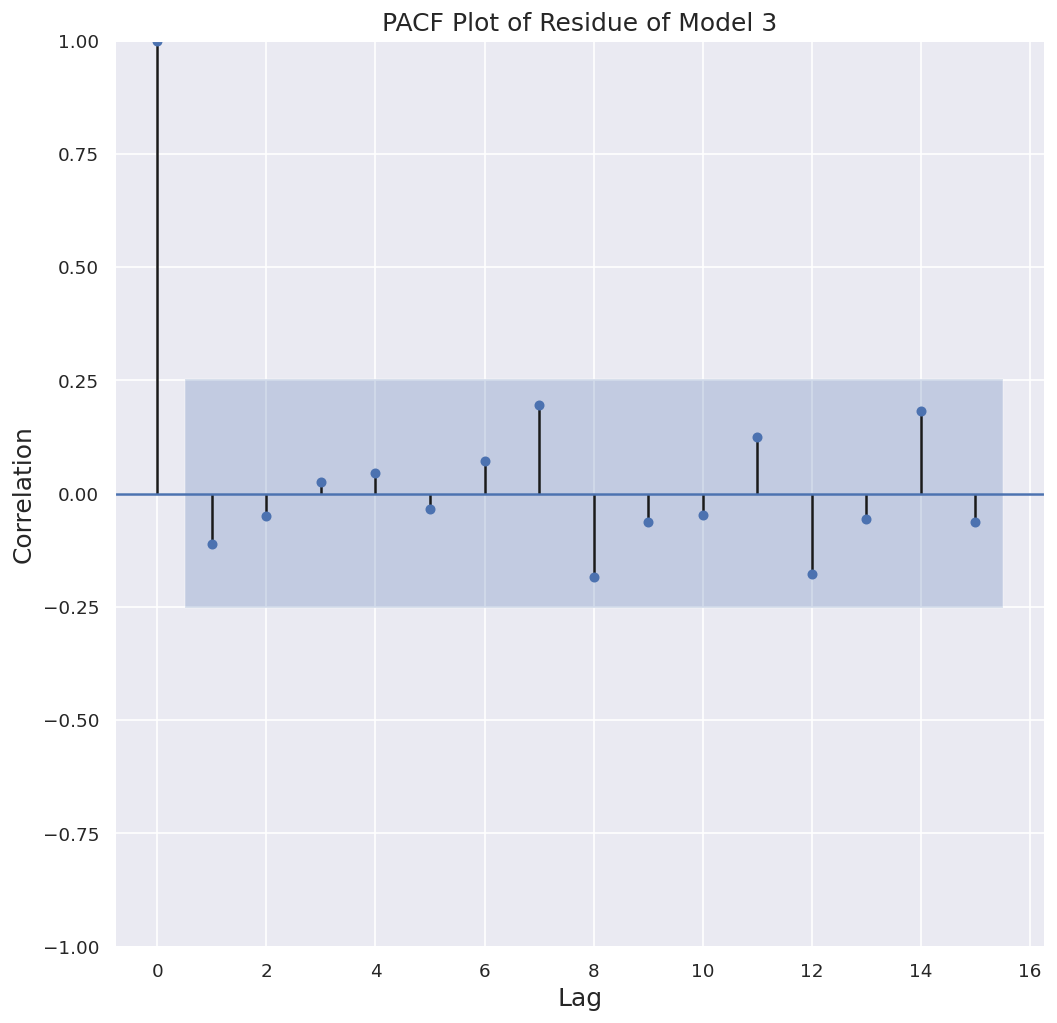

In [ ]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig = plt.figure(figsize=(16,3), dpi= 100)
#axes1 = fig.add_subplot(121)
#plot_acf(df32, lags=35, ax=axes1)
plot_acf(residuals3, lags=15)

plt.title("ACF Plot of Residue of Model 3", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("ACF-re3.png")
plt.savefig(f"{images_dir}/ACF-re3.png")

#axes2 = fig.add_subplot(122)
#plot_pacf(df32, lags=35, ax=axes2)
plot_pacf(residuals2, lags=15)
plt.title("PACF Plot of Residue of Model 3", fontsize=15)
plt.ylabel("Correlation",fontsize=15)
plt.xlabel("Lag",fontsize=15)
plt.savefig("PACF-res3.png")
plt.savefig(f"{images_dir}/PACF-res3.png")
plt.show()


# Error Calculation

In [ ]:
def calculate_error_measures(X, Y):
    
    """
    Function to calculate the mean squared error, mean absolute error and the coefficient of determination (r2) between two lists.
    ...
    Attributes
    ----------
    X : list
    
    Y : list
    
    """
    
        
    MSE = mean_squared_error(X, Y)
    print('Mean Squared Error(MSE): ', MSE)
    
    MAE = mean_absolute_error(X, Y)
    print('Mean Absolute Error(MAE): ', MAE)
    RMSE =mean_squared_error(X, Y,squared=False)
    print('Root Mean Squared Error(RMSE):', RMSE )
    MAPE = mean_absolute_percentage_error(X, Y)
    print(' Mean absolute percentage Error(MAPE):', MAPE )
    #squared bool, default=True If True returns MSE value, if False returns RMSE value.
    error_measures = [MSE, MAE,RMSE, MAPE]
    return error_measures

In [ ]:
print("Error measures for ARIMA model-1:")
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(calculate_error_measures(test_data, fcast['mean']))

print("Error measures for ARIMA model-2:")
print(calculate_error_measures(test_data, fscast['mean']))

print("Error measures for ARIMA model-3:")
print(calculate_error_measures(test_data, fscast3['mean']))

Error measures for ARIMA model-1:
Mean Squared Error(MSE):  240.53172162030205
Mean Absolute Error(MAE):  13.387272612677105
Root Mean Squared Error(RMSE): 15.509085131635008
 Mean absolute percentage Error(MAPE): 0.10256863792596413
[240.53172162030205, 13.387272612677105, 15.509085131635008, 0.10256863792596413]
Error measures for ARIMA model-2:
Mean Squared Error(MSE):  436.1765057756324
Mean Absolute Error(MAE):  18.618695525042412
Root Mean Squared Error(RMSE): 20.884839136934534
 Mean absolute percentage Error(MAPE): 0.1435663425235242
[436.1765057756324, 18.618695525042412, 20.884839136934534, 0.1435663425235242]
Error measures for ARIMA model-3:
Mean Squared Error(MSE):  778.1345279765296
Mean Absolute Error(MAE):  24.340246592360153
Root Mean Squared Error(RMSE): 27.895062788538937
 Mean absolute percentage Error(MAPE): 0.19044591571351976
[778.1345279765296, 24.340246592360153, 27.895062788538937, 0.19044591571351976]


#State Space Methods

In [ ]:
# Load the statsmodels api
import statsmodels.api as sm

# Load your dataset
endog = data32_i

# Fit a local level model
mod_ll = sm.tsa.UnobservedComponents(endog, 'local level')
# Note that mod_ll is an instance of the UnobservedComponents class

# Fit the model via maximum likelihood
res_ll = mod_ll.fit()
# Note that res_ll is an instance of the UnobservedComponentsResults class

# Show the summary of results
print(res_ll.summary())

# Show a plot of the estimated level and trend component series
fig_ll = res_ll.plot_components()

# We could further add a damped stochastic cycle as follows
mod_cycle = sm.tsa.UnobservedComponents(endog, 'local level', cycle=True,
                                        damped_cycle=True,
                                        stochastic_cycle=True)
res_cycle = mod_cycle.fit()

# Show the summary of results
print(res_cycle.summary())

# Show a plot of the estimated level, trend, and cycle component series
fig_cycle = res_cycle.plot_components()

NameError: ignored